# 猫狗大战毕业项目

数据集
[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

### 1. 数据预处理
#### 1.1 利用keras的`ImageDataGenerator` 函数进行统一的预处理，生成批次的带实时数据增益的张量图像数据, `ImageDataGenerator` 需要将不同类别的图片分类后放置到相同的目录内；这里准备使用创建文件软链接的方式来分类文件

In [1]:
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
import os
import shutil
import numpy as np
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
# from pprint import pprint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import h5py
import matplotlib.pyplot as plt
import random
import cv2

CUR_PATH = os.getcwd()
ORG_TRAIN_DIR = CUR_PATH +'/all/train/'
ORG_TEST_DIR = CUR_PATH + '/all/test/'
TRAIN_DIR = CUR_PATH + "/input/train"
TRAIN_CAT_DIR = TRAIN_DIR + "/cat/"
TRAIN_DOG_DIR = TRAIN_DIR + "/dog/"
TEST_DIR = CUR_PATH + "/input/test"
H5PY_PATH = CUR_PATH + "/saved_models/"

Using TensorFlow backend.


In [2]:
def sort_img(dir_path):
    '''判断图片是猫还是狗'''
    train_filenames = os.listdir(dir_path)
#     print(train_filenames)
    train_cat = list(filter(lambda x:x.split('.')[0] == 'cat', train_filenames))
    train_dog = list(filter(lambda x:x.split('.')[0] == 'dog', train_filenames))
    return train_cat , train_dog

def create_dir(dir_path):
    '''建立指定的目录'''
    remove_dir(dir_path)
    cmd = "mkdir -p " + dir_path
    os.system(cmd)

def remove_dir(dir_path):
    cmd = "rm -rf " + dir_path
    os.system(cmd)

def create_symlink(ori_path,tar_apth):
    cmd = "ln -s " + ori_path + ' ' + tar_apth
    os.system(cmd)

def process_train_data(data_list, org_path, tar_path):
    '''建立分猫狗分类目录及软链接'''
    create_dir(tar_path)
    for img in tqdm(data_list):
        create_symlink(org_path + img,tar_path + img)

In [3]:
cat, dog = sort_img(ORG_TRAIN_DIR) #分别建立猫狗数据

In [4]:
process_train_data(cat,ORG_TRAIN_DIR,TRAIN_CAT_DIR) 
process_train_data(dog,ORG_TRAIN_DIR,TRAIN_DOG_DIR)

create_dir(TEST_DIR)
create_symlink(ORG_TEST_DIR,TEST_DIR)

100%|██████████| 12500/12500 [01:00<00:00, 205.16it/s]


#### 1.2 数据探索

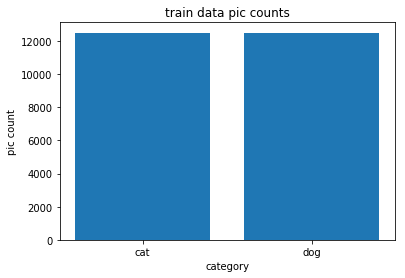

In [5]:
x =np.array([len(cat),len(dog)])
plt.bar(['cat','dog'],[x[0],x[1]])
plt.xlabel('category')
plt.ylabel('pic count')
plt.title('train data pic counts')
plt.show()

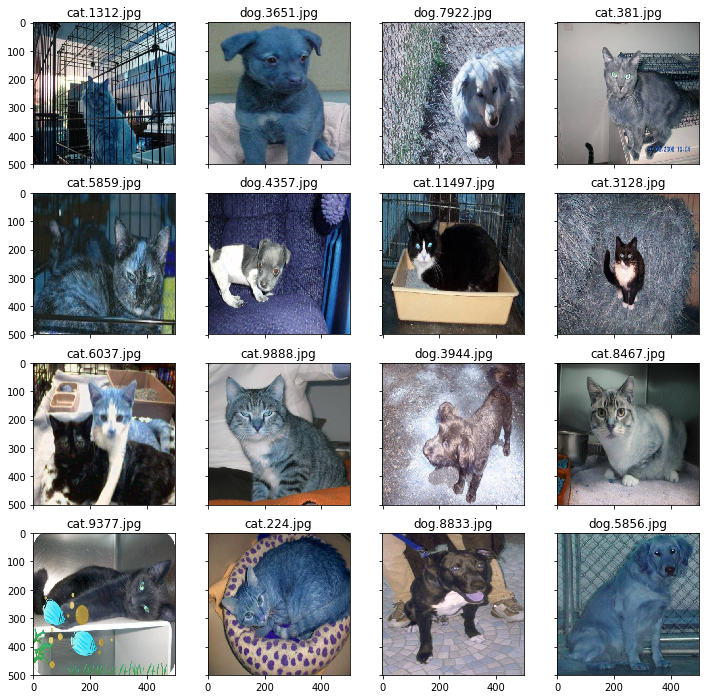

In [6]:
random.seed(2018)
#查看图片内容
fig,ax = plt.subplots(4,4,sharex='col',sharey='row',figsize=(12,12))
train_filenames = os.listdir(ORG_TRAIN_DIR)
#随机获取图片
for i in range(4):
    for j in range(4):
        ran = random.randint(0,len(train_filenames))
        img = cv2.imread(ORG_TRAIN_DIR + train_filenames[ran])
        img = cv2.resize(img, (500,500))
        ax[i,j].set_title('%s'% train_filenames[ran])
        ax[i,j].imshow(img)

### 2 导出特征向量

keras的提供了可选的模型

模型|	大小|	Top-1 准确率	|Top-5准确率|	参数数量|	深度
----|---|---|---|---|---
Xception	|88 MB	|0.790	|0.945|	22,910,480	|126
VGG16	|528 MB	|0.715	|0.901	|138,357,544	|23
VGG19	|549 MB	|0.727|	0.910	|143,667,240	|26
ResNet50|	99 MB	|0.759	|0.929	|25,636,712|168
InceptionV3	|92 MB|	0.788|	0.944	|23,851,784|	159
InceptionResNetV2|	215 MB	|0.804	|0.953	|55,873,736|	572
MobileNet	|17 MB|	0.665|	0.871|	4,253,864	|88
DenseNet121	|33 MB	|0.745|	0.918	|8,062,504	|121
DenseNet169	|57 MB|	0.759	|0.928|	14,307,880	|169
DenseNet201	|80 MB|	0.770|	0.933	|20,242,984	|201

这里只使用 InceptionV3 和 Xception 这两个模型。

In [7]:
def write_gap(MODEL, image_size, lambda_func=None):
   
    h5_full_path =  H5PY_PATH + MODEL.__name__ + '.h5'
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(TRAIN_DIR, image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory(TEST_DIR, image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    model.summary()
#     pprint(MODEL.__name__)
#     return

    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    remove_dir(h5_full_path)
    
    with h5py.File(h5_full_path) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [8]:
# write_gap(ResNet50, (224, 224))
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
_______________________

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 299, 299, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_2[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
_______________________

In [28]:
#  定义导入特征向量函数
def load_eigenvector(path_list=[]):
    x_train = []
    x_test = []
    for file_path in path_list:
        with h5py.File(file_path, 'r') as fp:
            x_train.append(np.array(fp['train']))
            x_test.append(np.array(fp['test']))
            y_train = np.array(fp['label'])

    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, y_train, x_test

# 增加全连接层
def full_connect_layer(x_train, dropout_rate = 0.2):
    input_tensor = Input(x_train.shape[1:])
    model = Model(input_tensor, Dropout(dropout_rate)(input_tensor))
    model = Model(model.input, Dense(1, activation = 'sigmoid')(model.output))
    # 编译模型
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# 训练函数
def model_fit(model,x_train,y_train,chk_point_file,epochs = 10,batch_size = 128):
    remove_dir(chk_point_file)
    history_train = model.fit(x_train, y_train, validation_split = 0.2,epochs = epochs, 
                              batch_size = batch_size, verbose=1,
                              callbacks=[ModelCheckpoint(filepath=chk_point_file, verbose=1, save_best_only=True)])
    return history_train

# 定义打印训练历史
def plt_history(data) :
    plt.plot(data.history['val_loss'])
    plt.xlabel('time')
    plt.ylabel('val_loss')
    plt.show()
    
    plt.plot(data.history['val_acc'])
    plt.xlabel('times')
    plt.ylabel('val_acc')
    plt.show()

### 尝试1. 导入保存的权重InceptionV3

In [ ]:
# file_name = H5PY_PATH + "InceptionV3.h5"
# x_train, y_train = load_eigenvector([file_name])
# inception_v3_model = full_connect_layer(x_train)

# SVG(model_to_dot(inception_v3_model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# # 训练
# chk_point_file = H5PY_PATH +'InceptionV3.best.h5'
# history_train = model_fit(inception_v3_model,x_train,y_train,chk_point_file)

In [ ]:
# plt_history(history_train)

### 尝试2. 导入Xception模型权重

In [ ]:
# file_name = H5PY_PATH + "Xception.h5"
# x_train, y_train = load_eigenvector([file_name])
# Xception = full_connect_layer(x_train)

# SVG(model_to_dot(Xception, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# chk_point_file = H5PY_PATH +'Xception.best.h5'
# history_train = model_fit(Xception,x_train,y_train,chk_point_file)

In [ ]:
# plt_history(history_train)

### 尝试3. 导入混合模型权重

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


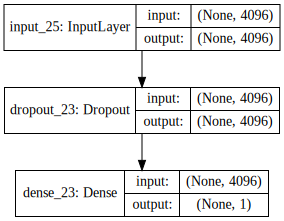

In [29]:
file_list = [H5PY_PATH + "Xception.h5", H5PY_PATH + "InceptionV3.h5"]
x_train, y_train, x_test = load_eigenvector(file_list)
Xception_IncV3 = full_connect_layer(x_train,dropout_rate=0.2)

SVG(model_to_dot(Xception_IncV3, show_shapes=True).create(prog='dot', format='svg'))

In [30]:
chk_point_file = H5PY_PATH +'Xception_IncV3.best.h5'
history_train = model_fit(Xception_IncV3,x_train,y_train,chk_point_file)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 135us/step - loss: 0.0690 - acc: 0.9848 - val_loss: 0.0220 - val_acc: 0.9938

Epoch 00001: val_loss improved from inf to 0.02196, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception_IncV3.best.h5
Epoch 2/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0210 - acc: 0.9941 - val_loss: 0.0172 - val_acc: 0.9938

Epoch 00002: val_loss improved from 0.02196 to 0.01721, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception_IncV3.best.h5
Epoch 3/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0169 - acc: 0.9950 - val_loss: 0.0151 - val_acc: 0.9946

Epoch 00003: val_loss improved from 0.01721 to 0.01509, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception_IncV3.best.h5
Epoch 4/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0140 - acc: 0.9956 - val_loss: 0.014

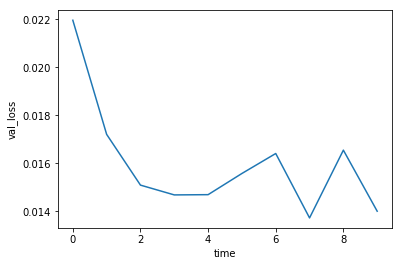

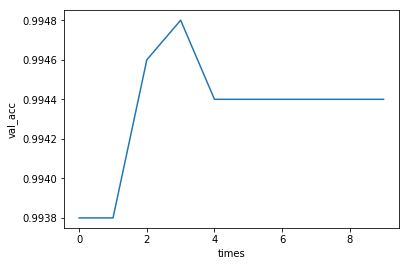

In [31]:
plt_history(history_train)

### 尝试不同的dropout保留率
尝试范围0.1-0.9

In [32]:
epochs = 10
dropout_result= []
for rate in np.arange(0.1, 1.0, 0.1):
    model =  full_connect_layer(x_train, dropout_rate=rate)
    train_result = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2)
    dropout_result.append((rate,train_result.history['val_loss'],train_result.history['val_acc']))
#     print(dropout_result)
#     break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 135us/step - loss: 0.0753 - acc: 0.9797 - val_loss: 0.0231 - val_acc: 0.9936
Epoch 2/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0212 - acc: 0.9944 - val_loss: 0.0173 - val_acc: 0.9942
Epoch 3/10
20000/20000 [==============================] - 1s 32us/step - loss: 0

20000/20000 [==============================] - 1s 32us/step - loss: 0.0121 - acc: 0.9962 - val_loss: 0.0145 - val_acc: 0.9942
Epoch 9/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0110 - acc: 0.9969 - val_loss: 0.0155 - val_acc: 0.9944
Epoch 10/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0107 - acc: 0.9965 - val_loss: 0.0149 - val_acc: 0.9948
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Tra

20000/20000 [==============================] - 1s 33us/step - loss: 0.0228 - acc: 0.9936 - val_loss: 0.0162 - val_acc: 0.9938
Epoch 6/10
20000/20000 [==============================] - 1s 33us/step - loss: 0.0230 - acc: 0.9932 - val_loss: 0.0144 - val_acc: 0.9940
Epoch 7/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0208 - acc: 0.9940 - val_loss: 0.0152 - val_acc: 0.9944
Epoch 8/10
20000/20000 [==============================] - 1s 33us/step - loss: 0.0205 - acc: 0.9942 - val_loss: 0.0140 - val_acc: 0.9942
Epoch 9/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0198 - acc: 0.9945 - val_loss: 0.0139 - val_acc: 0.9942
Epoch 10/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.0220 - acc: 0.9937 - val_loss: 0.0140 - val_acc: 0.9946
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 4096)              0

In [33]:
## dropout rate and val_loss
pd_data = []
for index in range(len(dropout_result)):
    row = []
    num = dropout_result[index][1]
    row.append(np.average(num))
    row.append(np.max(num))
    row.append(np.min(num))
    pd_data.append(row)

val_loss_df = pd.DataFrame(
    data=pd_data,
    index=np.arange(0.1, 1.0, 0.1),
    columns=['Avg', 'Max', 'Min']
)
val_loss_df.index.name = 'dropout rate'
val_loss_df

,Avg,Max,Min
dropout rate,,,
0.1,0.015517,0.023084,0.013810
0.2,0.015878,0.022812,0.013757
0.3,0.016578,0.026895,0.014370
0.4,0.015862,0.022648,0.014410
0.5,0.015565,0.022074,0.014042
0.6,0.015893,0.024777,0.013124
0.7,0.015686,0.024650,0.013588
0.8,0.016551,0.025151,0.013856
0.9,0.017931,0.029517,0.015050


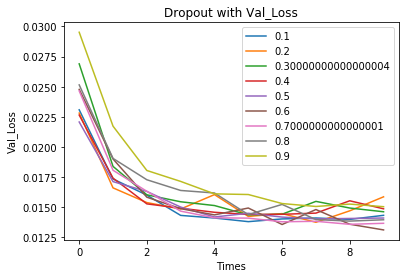

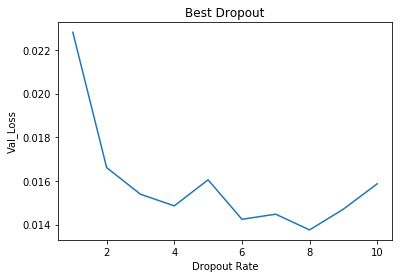

In [34]:
for index in range(len(dropout_result)):
    plt.plot(dropout_result[index][1],label=dropout_result[index][0])

plt.title('Dropout with Val_Loss')
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.legend()
plt.show() 


## best dropout
plt.title('Best Dropout')
plt.plot(np.arange(1,11,1),[x for x in dropout_result[1][1]])
plt.xlabel('Dropout Rate')
plt.ylabel('Val_Loss')
plt.show()

预测测试集

In [39]:
y_pred = Xception_IncV3.predict(x_test)
y_pred = y_pred.clip(min = 0.005, max = 0.995)

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(TEST_DIR, (299, 299), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.at[index-1, 'label'] = y_pred[i]

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
